In [2]:
import numpy as np
import pandas as pd
import pickle
# SQL related packages
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
# sklearn packages
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics, preprocessing
from sklearn.linear_model import LogisticRegression as Log
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.metrics.scorer import make_scorer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
# text analysis packages
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
import gensim
from gensim.models.keyedvectors import KeyedVectors
from gensim.models import word2vec, Word2Vec

import matplotlib.pyplot as plt
%matplotlib inline

## Train Word2Vec model using patent claims
### Read data from SQL database

In [2]:
# access to sql database
dbname = 'patent_db'
username = 'jy'
pswd = 'jy'

engine = create_engine('postgresql://%s:%s@localhost/%s'%(username,pswd,dbname))

# reading from sql database
# connect:
con = None
con = psycopg2.connect(database = dbname, user = username, host='localhost', password=pswd)

#### First load patents from 2004-2007
It is the save dataset for training the final model. Only the training data are used to train the word2vec model. The test data are held out from any model training. 

In [3]:
# read data from 2004-2007
years = np.arange(2004, 2008)

# dataframe to store the results
claims = pd.DataFrame()

# import the abstract from each table
for year in years:
    # query:
    sql_query = """
    SELECT claims, id, payment_times, classification
        FROM patents_%s;
    """ %str(year)

    results = pd.read_sql_query(sql_query,con)
    
    claims = pd.concat([claims, results], axis = 0)
    
# check size of the data
claims.shape

(12033, 4)

In [4]:
# extract the response variable
# reformat the response variable into binary
y_data = np.zeros(claims.shape[0])
y_data[claims['payment_times'].values >= 2] = 1

print "Percentage of patents with > 1 maintenance fee payments: ", np.mean(y_data)

Percentage of patents with > 1 maintenance fee payments:  0.628521565694


In [5]:
# remove the patents missing classification data
missing_class_index = (claims['classification'].values == 'NA')

# reassign patent index
claims.index = range(len(claims.index))
# drop the rows
claims =  claims.drop(claims.index[missing_class_index])
claims.shape

(12030, 4)

In [6]:
# drop the same rows in the response variable
y_data = y_data[claims['classification'].values != 'NA']
y_data.shape

(12030,)

Split the training and testing data using the same seed as in the final model training, in order to extract the same training data. The training data will be combined with additional patents to train the word2vec model.

In [7]:
# split train and test sets
x_train, x_test, y_train, y_test = train_test_split(claims, y_data[:claims.shape[0]], 
                                                    test_size = 2000, 
                                                    random_state = 123)

print "Dataset dimensions:"
print "x_train: ", x_train.shape
print "x_test: ", x_test.shape
print "y_train: ", y_train.shape
print "y_test: ", y_test.shape

Dataset dimensions:
x_train:  (10030, 4)
x_test:  (2000, 4)
y_train:  (10030,)
y_test:  (2000,)


#### Read additional patents from 2008-2010

In [8]:
# read data from 2008-2010
years = np.arange(2008, 2011)

# dataframe to store the results
claims = pd.DataFrame()

# import the abstract from each table
for year in years:
    # query:
    sql_query = """
    SELECT claims, id, payment_times, classification
        FROM patents_%s;
    """ %str(year)

    results = pd.read_sql_query(sql_query,con)
    
    claims = pd.concat([claims, results], axis = 0)
    
# check size of the data
claims.shape

(11172, 4)

#### Combine the training data from 2004-2007 with the patents from 2008-2010

In [10]:
# combine new claims with x_train
train_data = pd.concat([x_train, claims], axis = 0)

### Train word2vec model
#### Tokenize the data

In [8]:
### Function to tokenize and clean a piece of text
# input: a string of text
# output: list of tokens (cleaned words) extracted from the text 
# the function lowercases all words, eliminates English stop words, 
# turns words into lemma and remove tokens with any number in it
def tokenize_cleaning(text):
    # tokenize the text first
    tokens = word_tokenize(text.decode('utf-8'))
    
    # lowercase all the words
    tokens = [w.lower() for w in tokens]
    
    # clean up stop words and punctuations 
    stop_list = stopwords.words('english') + list(string.punctuation)

    tokens_no_stop = [token for token in tokens
                        if token not in stop_list]            

    # use lemma instead
    # reason: remove the influence of plural or tense
    # but retain the subtle difference in legal writting
    lemmatizer = WordNetLemmatizer()
    tokens_lemma = [lemmatizer.lemmatize(token) for token in tokens_no_stop]
    
    # remove numbers (the actual values are not useful for the task)
    tokens_no_num = []
    for token in tokens_lemma:
        try:
            float(token)
        except:
            tokens_no_num.append(token)
    
    return tokens_no_num

In [12]:
# tokenize_clean the patent claims for word2vec training

cleaned_text = []
for i in range(train_data.shape[0]):
    tokens = tokenize_cleaning(train_data['claims'].iloc[i])
    cleaned_text.append(tokens)

In [15]:
# check the size
len(cleaned_text)

21202

#### Train word2vec

In [13]:
# train a word2vec model
model = Word2Vec(cleaned_text, size=100, window=5, min_count=5, workers=4)

#### Check the trained model

In [4]:
# sanity check on example words
model.wv.most_similar(positive=['protein'])

[(u'polypeptide', 0.693970799446106),
 (u'glycoprotein', 0.6489318609237671),
 (u'subunit', 0.6218897104263306),
 (u'adp', 0.6021888256072998),
 (u'repressor', 0.5989565849304199),
 (u'kinase', 0.5918909311294556),
 (u'fusion', 0.5866469740867615),
 (u'mbp', 0.5858468413352966),
 (u'translocation', 0.5848914980888367),
 (u'kda', 0.5842524766921997)]

In [21]:
model.wv.most_similar(positive=['computer'])

[(u'processor', 0.696655809879303),
 (u'microprocessor', 0.6668151617050171),
 (u'software', 0.6461315155029297),
 (u'executable', 0.6111671924591064),
 (u'computer-readable', 0.6046246886253357),
 (u'sub-code', 0.6031157970428467),
 (u'electronically', 0.6021907925605774),
 (u'program', 0.5960052013397217),
 (u'hyperlink', 0.5921428203582764),
 (u'programmed', 0.5846973061561584)]

In [22]:
# save the word2vec model
model.save('models/word2vec_claims_final')

### Predict patent usefulness using the word2vec model
#### Load the model

In [3]:
# load the word2vec model
model = Word2Vec.load('models/word2vec_claims_final')

#### Load and clean the data

In [23]:
# read data from 2004-2007
years = np.arange(2004, 2008)

# dataframe to store the results
claims = pd.DataFrame()

# import the abstract from each table
for year in years:
    # query:
    sql_query = """
    SELECT claims, id, payment_times, classification
        FROM patents_%s;
    """ %str(year)

    results = pd.read_sql_query(sql_query,con)
    
    claims = pd.concat([claims, results], axis = 0)
    
# check size of the data
claims.shape

(12033, 4)

In [10]:
# remove the patents missing classification data
missing_class_index = (claims['classification'].values == 'NA')

# reassign patent index
claims.index = range(len(claims.index))
# drop the rows
claims =  claims.drop(claims.index[missing_class_index])
claims.shape

(12030, 4)

In [11]:
# drop the same rows in the response variable
y_data = y_data[claims['classification'].values != 'NA']
y_data.shape

(12030,)

#### Process data by the word2vec model

In [12]:
# tokenize_clean for training the final model

cleaned_text = []
for i in range(claims.shape[0]):
    tokens = tokenize_cleaning(claims['claims'].iloc[i])
    cleaned_text.append(tokens)

In [13]:
### Function to compute average word-vector for a text
# input: word2vec model and a string of text
# ouput: one vector
# the function compute word2vec vector on each word
# and return the average vector for the text
def dec_vec(model, text):
    # store the vectors for all the words
    vectors = []
    
    # compute on each word
    for j in range(len(text)):
        try:
            vectors.append(model.wv[text[j]])
        except:
            continue
    # zero if the claim is missing
    if not vectors:
        vectors_mean = np.zeros((1, 100))
    # otherwise compute the mean vector
    else:
        vectors_mean = np.nanmean(vectors, axis = 0)
        vectors_mean = vectors_mean.reshape((1, 100))
    
    # return vector mean
    return vectors_mean

In [14]:
# compute average vector for each patent
# initialize by a zero vector
claims_vec = np.zeros((1, 100))

for i in range(claims.shape[0]):
    vec = dec_vec(model, cleaned_text[i])
    claims_vec = np.concatenate([claims_vec, vec], axis = 0)

# remove the initialized vector
claims_vec = claims_vec[1:, :]
# check the data dimension
claims_vec.shape

(12030, 100)

#### Split train/test data and subsampling

In [15]:
# split the training and testing data
# split train and test sets
x_train, x_test, y_train, y_test = train_test_split(claims_vec, y_data, 
                                                    test_size = 2000, 
                                                    random_state = 123)

print "Dataset dimensions:"
print "x_train: ", x_train.shape
print "x_test: ", x_test.shape
print "y_train: ", y_train.shape
print "y_test: ", y_test.shape

Dataset dimensions:
x_train:  (10030, 100)
x_test:  (2000, 100)
y_train:  (10030,)
y_test:  (2000,)


In [16]:
# sample the same number of'useful' patents as the 'not useful' patents
# size of each class
num_size = np.sum(y_data == 0)

#random shuffle the rows
n = x_train.shape[0]
perm = range(n)
np.random.shuffle(perm)

x_train = x_train[perm]
y_train = y_train[perm]

# separate the two classes
x_useful = x_train[y_train == 1, :]
x_not_useful = x_train[y_train == 0, :]
y_useful = y_train[y_train == 1]
y_not_useful = y_train[y_train == 0]

# sample num_size from the 'useful' class
x_useful = x_useful[:num_size]
y_useful = y_useful[:num_size]

# combine the two classes
x_data_sub = np.concatenate((x_useful, x_not_useful), axis = 0)
y_data_sub = np.concatenate((y_useful, y_not_useful), axis = 0)

# shuffle again
# shuffle the combined data
n2 = x_data_sub.shape[0]
perm2 = range(n2)
np.random.shaiuffle(perm2)

x_data_sub = x_data_sub[perm2]
y_data_sub = y_data_sub[perm2]

# check the size
print x_data_sub.shape
print y_data_sub.shape

(8217, 100)
(8217,)


#### Model training

In [17]:
# standardize the predictors
scaler = preprocessing.StandardScaler()

x_train_std = scaler.fit_transform(x_data_sub)
x_test_std = scaler.transform(x_test)

In [25]:
# write my own scoring function
# compute net value of investment based on estimated cost and value
def my_loss_func(y_actual, y_pred):
    
    # set the price of applying for each patent
    patent_cost = 20
    
    # set the value of a useful patent
    useful_value = 30
    
    total_cost = np.sum(y_pred == 1) * patent_cost
    total_value = np.sum((y_actual == 1) & (y_pred == 1)) * useful_value
    
    profit = total_value -  total_cost
    
    return profit

my_scorer = make_scorer(my_loss_func, greater_is_better=True)

In [26]:
### tune random forest

model = RandomForestClassifier(n_estimators = 100)

# tune max_features
param_space = np.arange(6, 16, 2)

grid_model = GridSearchCV(model, n_jobs = 4, 
                          param_grid = {'max_features': param_space}, 
                          cv  = 5, scoring = my_scorer)
# fit on the data
grid_model = grid_model.fit(x_train_std, y_data_sub)

In [27]:
# check CV results
print "Best accuracy:", grid_model.best_score_
print "Best parameter: ", grid_model.best_params_

Best accuracy: -3336.00827553
Best parameter:  {'max_features': 14}


In [28]:
# check testing results
# fit the final model on the training data
best_rf = grid_model.best_estimator_
best_rf.fit(x_train_std, y_data_sub)

# predict on the testing data
y_pred = best_rf.predict(x_test_std)

# metrics
print "Test accuracy: ", np.mean(y_pred == y_test)
print "F1 score: ", metrics.f1_score(y_test, y_pred)
print "Precision: ", metrics.precision_score(y_test, y_pred)
print "Recall: ", metrics.recall_score(y_test, y_pred)
print "Net value: ", my_loss_func(y_test, y_pred)
metrics.confusion_matrix(y_test, y_pred)

Test accuracy:  0.5885
F1 score:  0.69325382035
Precision:  0.662393162393
Recall:  0.727130570758
Net value:  -180


array([[247, 474],
       [349, 930]])

### Visualization
#### Visualize the test data using tSNE

In [36]:
# transform the predictors using tSNE
tSNE = TSNE(n_components=2)

x_tsne = tSNE.fit_transform(x_train_std)
x_tsne.shape

(8217, 2)

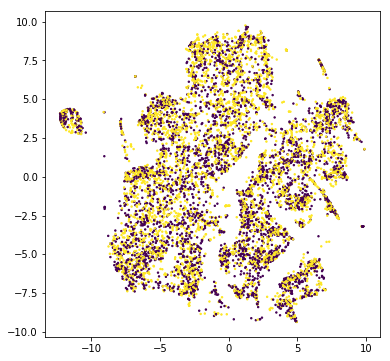

In [43]:
fig = plt.figure(figsize = (6, 6))

plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c = y_data_sub, s = 2)

#### Visualize the test data using PCA

In [46]:
# transform the predictors using tSNE
pca = PCA(n_components=2)

x_pca = pca.fit_transform(x_train_std)
x_pca.shape

(8217, 2)

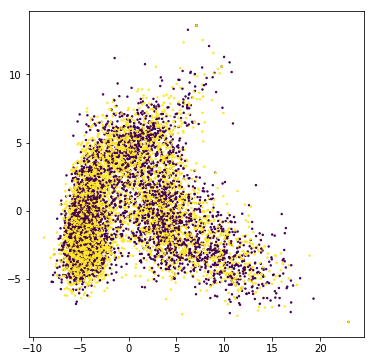

In [47]:
fig = plt.figure(figsize = (6, 6))

plt.scatter(x_pca[:, 0], x_pca[:, 1], c = y_data_sub, s = 2)